In [29]:
import pandas as pd
import glob

path = "LoLesports_data"

all_files = glob.glob(path + "/*.csv")

df_list = []

for file in all_files[-3:]:
    temp_df = pd.read_csv(file, low_memory=False)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
df = df[df["datacompleteness"] == "complete"]
df.drop(columns=["datacompleteness", "url"], inplace=True)

print(df.head())
print(len(df))

                  gameid league  year   split  playoffs                 date  \
0  ESPORTSTMNT01_2690210   LCKC  2022  Spring         0  2022-01-10 07:44:08   
1  ESPORTSTMNT01_2690210   LCKC  2022  Spring         0  2022-01-10 07:44:08   
2  ESPORTSTMNT01_2690210   LCKC  2022  Spring         0  2022-01-10 07:44:08   
3  ESPORTSTMNT01_2690210   LCKC  2022  Spring         0  2022-01-10 07:44:08   
4  ESPORTSTMNT01_2690210   LCKC  2022  Spring         0  2022-01-10 07:44:08   

   game  patch  participantid  side  ... opp_csat25 golddiffat25 xpdiffat25  \
0     1  12.01              1  Blue  ...        NaN          NaN        NaN   
1     1  12.01              2  Blue  ...        NaN          NaN        NaN   
2     1  12.01              3  Blue  ...        NaN          NaN        NaN   
3     1  12.01              4  Blue  ...        NaN          NaN        NaN   
4     1  12.01              5  Blue  ...        NaN          NaN        NaN   

  csdiffat25 killsat25 assistsat25 deathsat2

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333420 entries, 0 to 392447
Columns: 159 entries, gameid to opp_deathsat25
dtypes: float64(126), int64(12), object(21)
memory usage: 407.0+ MB


- 팀, 선수 데이터 분리

In [31]:
teams = df[df["position"] == "team"].reset_index(drop=True)
players = df[df["position"] != "team"].reset_index(drop=True)

teams.shape, players.shape

((55570, 159), (277850, 159))

- 팀 데이터 결측치 처리

In [5]:
drop_teams_cols = [
    "playername",
    "playerid",
    "position",
    "champion",
    "firstbloodkill",
    "firstbloodassist",
    "firstbloodvictim",
    "damageshare",
    "dragons (type unknown)",
    "earnedgoldshare",
    "total cs",
    "goldat20",
    "xpat20",
    "csat20",
    "opp_goldat20",
    "opp_xpat20",
    "opp_csat20",
    "golddiffat20",
    "xpdiffat20",
    "csdiffat20",
    "killsat20",
    "assistsat20",
    "deathsat20",
    "opp_killsat20",
    "opp_assistsat20",
    "opp_deathsat20",
    "goldat25",
    "xpat25",
    "csat25",
    "opp_goldat25",
    "opp_xpat25",
    "opp_csat25",
    "golddiffat25",
    "xpdiffat25",
    "csdiffat25",
    "killsat25",
    "assistsat25",
    "deathsat25",
    "opp_killsat25",
    "opp_assistsat25",
    "opp_deathsat25",
    "monsterkillsownjungle",
    "monsterkillsenemyjungle",
]

fill_zero_cols = [
    "game",
    "elementaldrakes",
    "opp_elementaldrakes",
    "chemtechs",
    "hextechs",
    "void_grubs",
    "opp_void_grubs",
    "turretplates",
    "opp_turretplates",
    "quadrakills",
    "pentakills",
    "heralds",
    "opp_heralds",
    "firstblood",
    "firstdragon",
    "dragons",
    "opp_dragons",
    "infernals",
    "mountains",
    "clouds",
    "oceans",
    "elders",
    "opp_elders",
    "firstherald",
    "firstbaron",
    "barons",
    "opp_barons",
    "firsttower",
    "firstmidtower",
    "inhibitors",
    "opp_inhibitors",
]

fill_unknown_cols = [
    "gameid",
    "teamname",
    "teamid",
    "ban1",
    "ban2",
    "ban3",
    "ban4",
    "ban5",
    "pick1",
    "pick2",
    "pick3",
    "pick4",
    "pick5",
    "split",
]

tmp = teams.drop(columns=drop_teams_cols)
tmp[fill_zero_cols] = tmp[fill_zero_cols].fillna(0)
tmp[fill_unknown_cols] = tmp[fill_unknown_cols].fillna("unknown")

In [6]:
missing_columns = tmp.columns[tmp.isnull().sum() > 0]
means = teams.groupby("teamid")[missing_columns].mean()

for col in missing_columns:
    total_mean = teams[col].mean()
    
    tmp[col] = tmp.apply(
        lambda row: (
            means.loc[row['teamid'], col] 
            if row['teamid'] in means.index and not pd.isnull(means.loc[row['teamid'], col])
            else total_mean
        ) if pd.isnull(row[col]) else row[col],
        axis=1
    )

In [7]:
tmp.isnull().sum().sum()

0

In [8]:
teams = tmp
teams.shape

(55570, 117)

- 선수 데이터 결측치 처리

In [9]:
players.shape

(277850, 159)

In [10]:
drop_players_cols = [
    "pick1",
    "pick2",
    "pick3",
    "pick4",
    "pick5",
    "firstdragon",
    "dragons",
    "opp_dragons",
    "dragons (type unknown)",
    "elementaldrakes",
    "opp_elementaldrakes",
    "infernals",
    "mountains",
    "clouds",
    "oceans",
    "chemtechs",
    "hextechs",
    "elders",
    "opp_elders",
    "firstherald",
    "heralds",
    "opp_heralds",
    "void_grubs",
    "opp_void_grubs",
    "firstbaron",
    "firsttower",
    "towers",
    "opp_towers",
    "firstmidtower",
    "firsttothreetowers",
    "turretplates",
    "opp_turretplates",
    "gspd",
    "gpr",
    "goldat20",
    "xpat20",
    "csat20",
    "opp_goldat20",
    "opp_xpat20",
    "opp_csat20",
    "golddiffat20",
    "xpdiffat20",
    "csdiffat20",
    "killsat20",
    "assistsat20",
    "deathsat20",
    "opp_killsat20",
    "opp_assistsat20",
    "opp_deathsat20",
    "goldat25",
    "xpat25",
    "csat25",
    "opp_goldat25",
    "opp_xpat25",
    "opp_csat25",
    "golddiffat25",
    "xpdiffat25",
    "csdiffat25",
    "killsat25",
    "assistsat25",
    "deathsat25",
    "opp_killsat25",
    "opp_assistsat25",
    "opp_deathsat25",
    "monsterkillsownjungle",
    "monsterkillsenemyjungle",
]

fill_zero_cols = [
    "game",
    "barons",
    "opp_barons",
    "quadrakills",
    "pentakills",
    "firstblood",
    "firstbloodkill",
    "firstbloodassist",
    "firstbloodvictim",
    "inhibitors",
    "opp_inhibitors",
]

fill_unknown_cols = [
    "split",
    "ban1",
    "ban2",
    "ban3",
    "ban4",
    "ban5",
    "gameid",
    "playername",
    "playerid",
    "teamname",
    "teamid",
]

tmp = players.drop(columns=drop_players_cols)
tmp[fill_zero_cols] = tmp[fill_zero_cols].fillna(0)
tmp[fill_unknown_cols] = tmp[fill_unknown_cols].fillna("unknown")

In [11]:
missing_columns = tmp.columns[tmp.isnull().sum() > 0]
means = players.groupby("playerid")[missing_columns].mean()

for col in missing_columns:
    total_mean = players[col].mean()
    
    tmp[col] = tmp.apply(
        lambda row: (
            means.loc[row['playerid'], col]
            if row['playerid'] in means.index and not pd.isnull(means.loc[row['playerid'], col])
            else total_mean
        ) if pd.isnull(row[col]) else row[col],
        axis=1
    )

In [12]:
tmp.isna().sum().sum()

0

In [13]:
players = tmp
players.shape

(277850, 94)

- 상대 팀 추가

In [14]:
temp_opp_teams = teams.groupby("gameid")["teamid"].transform(lambda x: x.iloc[::-1].values).to_frame("opp_teamid")
teams = pd.concat([teams, temp_opp_teams], axis=1)

temp_opp_players = players.groupby("gameid")["teamid"].transform(lambda x: x.iloc[::-1].values).to_frame("opp_teamid")
players = pd.concat([players, temp_opp_players], axis=1)

- 날짜 추가

In [15]:
teams["date"] = pd.to_datetime(teams["date"])
players["date"] = pd.to_datetime(players["date"])

teams["year"] = teams["date"].dt.year
teams["month"] = teams["date"].dt.month
teams["day"] = teams["date"].dt.day

players["year"] = players["date"].dt.year
players["month"] = players["date"].dt.month
players["day"] = players["date"].dt.day

teams.drop(columns=["date"], inplace=True)
players.drop(columns=["date"], inplace=True)

- 데이터 타입 변경

In [16]:
teams["league"] = teams["league"].astype("category")
teams["split"] = teams["split"].astype("category")
teams["teamid"] = teams["teamid"].astype("category")
teams["opp_teamid"] = teams["opp_teamid"].astype("category")

players["league"] = players["league"].astype("category")
players["split"] = players["split"].astype("category")
players["teamid"] = players["teamid"].astype("category")
players["playerid"] = players["playerid"].astype("category")
players["opp_teamid"] = players["opp_teamid"].astype("category")

- 인코딩

In [17]:
teams["side"] = teams["side"].map({"Blue": 0, "Red": 1})
players["side"] = players["side"].map({"Blue": 0, "Red": 1})

In [18]:
from sklearn.preprocessing import LabelEncoder

champion_columns_players = ['champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5']
champion_columns_teams = ['ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4', 'pick5']

champions = pd.concat([
    players[champion_columns_players],
    teams[champion_columns_teams]
]).stack().unique()

champions_df = pd.DataFrame({'champion': champions})
champions_df = champions_df.dropna().reset_index(drop=True)

le = LabelEncoder()
champions_df['champion_encoded'] = le.fit_transform(champions_df['champion'])

for col in champion_columns_players:
    players[col] = le.transform(players[col])

for col in champion_columns_teams:
    teams[col] = le.transform(teams[col])

In [19]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
players[ohe.get_feature_names_out()] = ohe.fit_transform(players[["position"]]).toarray()

players.drop(columns=["position"], inplace=True)

In [20]:
teams.select_dtypes("object").columns, players.select_dtypes("object").columns

(Index(['gameid', 'teamname'], dtype='object'),
 Index(['gameid', 'playername', 'teamname'], dtype='object'))

- 스케일링

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
players[players.select_dtypes("number").columns] = scaler.fit_transform(players[players.select_dtypes("number").columns])
teams[teams.select_dtypes("number").columns] = scaler.fit_transform(teams[teams.select_dtypes("number").columns])

- 모델 학습 및 검증

In [22]:
pre_game_features = [
    "patch",
    "side",
    "league",
    "teamid",
    "opp_teamid",
    "ban1",
    "ban2",
    "ban3",
    "ban4",
    "ban5",
    "pick1",
    "pick2",
    "pick3",
    "pick4",
    "pick5",
    "year",
    "month",
    "day",
]

In [23]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

teams['result'] = (teams['result'] > 0).astype(int)

cutoff_patch = teams["patch"].quantile(0.8)
train_games = teams[teams["patch"] < cutoff_patch]["gameid"].unique()
valid_games = teams[teams["patch"] >= cutoff_patch]["gameid"].unique()

train_x = teams[teams["gameid"].isin(train_games)][pre_game_features]
valid_x = teams[teams["gameid"].isin(valid_games)][pre_game_features]

train_y = teams[teams["gameid"].isin(train_games)]["result"]
valid_y = teams[teams["gameid"].isin(valid_games)]["result"]

cat_features = list(train_x.select_dtypes("category").columns)
catboost = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=3,
    cat_features=cat_features,
    verbose=100
)
catboost.fit(train_x, train_y)

pred_train = catboost.predict(train_x)
pred_valid = catboost.predict(valid_x)

print("\n훈련 정확도:", accuracy_score(train_y, pred_train))
print("검증 정확도:", accuracy_score(valid_y, pred_valid))

print("\n검증 세트 상세 성능:")
print(classification_report(valid_y, pred_valid))

0:	learn: 0.6901166	total: 163ms	remaining: 2m 42s
100:	learn: 0.6390868	total: 3.11s	remaining: 27.7s
200:	learn: 0.6338890	total: 6.16s	remaining: 24.5s
300:	learn: 0.6299096	total: 9.38s	remaining: 21.8s
400:	learn: 0.6266467	total: 12.7s	remaining: 19s
500:	learn: 0.6235290	total: 15.9s	remaining: 15.9s
600:	learn: 0.6206275	total: 19.2s	remaining: 12.8s
700:	learn: 0.6175034	total: 22.5s	remaining: 9.61s
800:	learn: 0.6146241	total: 25.8s	remaining: 6.42s
900:	learn: 0.6118743	total: 29.2s	remaining: 3.21s
999:	learn: 0.6091532	total: 32.4s	remaining: 0us

훈련 정확도: 0.7239963915200722
검증 정확도: 0.5933214603739982

검증 세트 상세 성능:
              precision    recall  f1-score   support

           0       0.59      0.60      0.59      5615
           1       0.59      0.59      0.59      5615

    accuracy                           0.59     11230
   macro avg       0.59      0.59      0.59     11230
weighted avg       0.59      0.59      0.59     11230



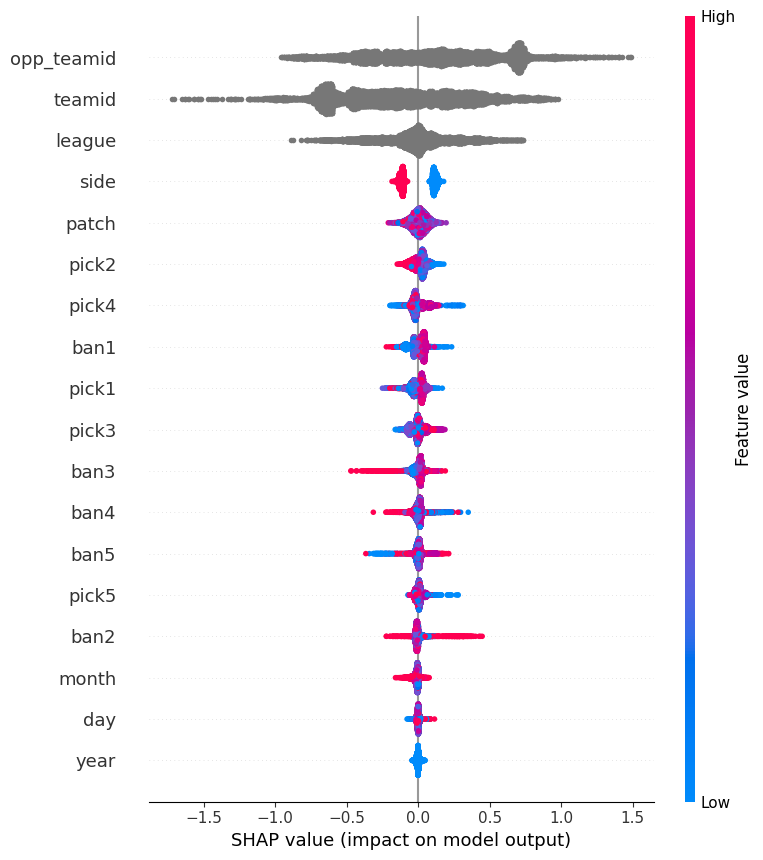

In [24]:
import shap

explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(valid_x)

shap.summary_plot(shap_values, valid_x)